# Network size scaling

In [6]:
import numpy as np 

arr = np.zeros((10,10))
arr.nbytes

800

In [7]:
arr = np.zeros((1,1))
arr.nbytes

8

In [44]:
n_nodes_range = np.unique(np.geomspace(1, 100_000, 25, dtype=int))
n_nodes_range

array([     1,      2,      4,      6,     11,     17,     28,     46,
           74,    121,    195,    316,    510,    825,   1333,   2154,
         3480,   5623,   9085,  14677,  23713,  38311,  61896, 100000])

In [45]:
n_edges_range = np.unique(np.geomspace(1, 10_000_000, 25, dtype=int))
n_edges_range

array([       1,        3,        7,       14,       28,       56,
            110,      215,      421,      825,     1615,     3162,
           6189,    12115,    23713,    46415,    90851,   177827,
         348070,   681292,  1333521,  2610157,  5108969, 10000000])

In [46]:
import pandas as pd 
from graspologic.utils import cartesian_product

def numpy_n_bytes(n_nodes, n_edges):
    return n_nodes * n_nodes * 8

pairs = cartesian_product(n_nodes_range, n_edges_range)

rows = []
for n, m in pairs:
    n_bytes = numpy_n_bytes(n, m)
    rows.append({'n_nodes':n, 'n_edges':m, 'n_bytes':n_bytes})

size_df = pd.DataFrame(rows)

<AxesSubplot:xlabel='n_nodes', ylabel='n_edges'>

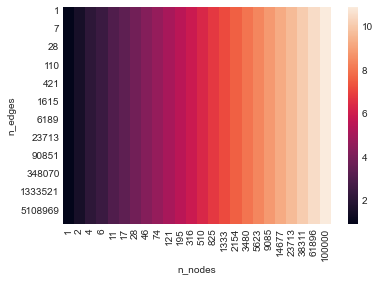

In [47]:
import seaborn as sns

square_size_df = size_df.pivot(index='n_edges', columns='n_nodes', values='n_bytes')
square_size_df = np.log10(square_size_df)

sns.heatmap(square_size_df)

In [36]:
my_mem = 16 * 1e9

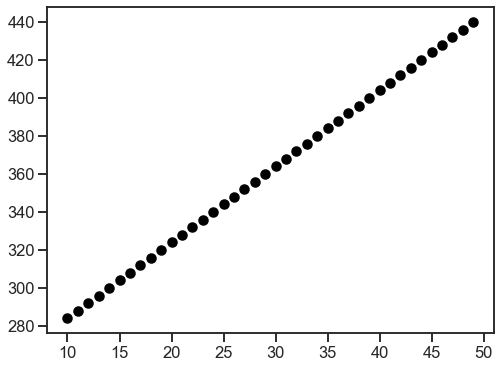

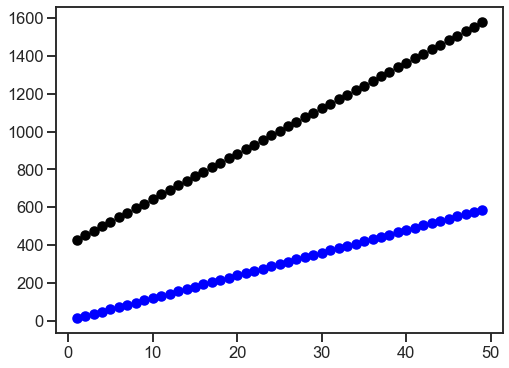

In [70]:
from scipy.sparse import csr_matrix
from graspologic.simulations import er_nm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')

fig, ax = plt.subplots(1, 1, figsize=(8,6))

m = 10
for n in range(10,50):
    A = er_nm(n, m)
    csr_mat = csr_matrix(A)
    n_bytes = csr_mat.data.nbytes + csr_mat.indptr.nbytes + csr_mat.indices.nbytes
    ax.scatter(n, n_bytes, color="black")


fig, ax = plt.subplots(1, 1, figsize=(8,6))
n = 100
for m in range(1, 50):
    A = er_nm(n, m)
    csr_mat = csr_matrix(A)
    n_bytes = csr_mat.data.nbytes + csr_mat.indptr.nbytes + csr_mat.indices.nbytes
    n_pred = 8*m + 4*m
    ax.scatter(m, n_bytes, color='black')
    ax.scatter(m, n_pred, color='blue')


In [71]:
csr_mat.indptr

array([ 0,  0,  1,  1,  2,  2,  2,  5,  5,  6,  8, 11, 11, 11, 11, 12, 12,
       12, 12, 13, 13, 16, 16, 16, 16, 17, 18, 18, 19, 21, 22, 22, 22, 23,
       26, 29, 29, 31, 31, 32, 35, 35, 36, 38, 39, 39, 41, 41, 42, 42, 44,
       46, 47, 48, 49, 51, 52, 52, 52, 52, 52, 54, 58, 61, 62, 63, 64, 64,
       65, 65, 65, 66, 66, 66, 67, 68, 69, 70, 70, 72, 77, 78, 81, 83, 84,
       85, 85, 87, 87, 87, 87, 87, 87, 87, 89, 91, 93, 93, 95, 97, 98],
      dtype=int32)

In [73]:
csr_mat.indices

98

In [80]:
A = er_nm(10, 5, directed=True)
csr_mat = csr_matrix(A)
len(csr_mat.indptr)

11

In [ ]:
ns = np.linspace(100, 100_000, 100)
ms = np.linspace(100, 10_000_000, 100)

# def sparse_n_bytes(n, m): 
#     return 2*m + 

In [103]:
ns = np.linspace(100, 1000, 10)
ms = np.linspace(1, 1000, 10)
n_bytes = []
for n in ns:
    for m in ms:
        A = er_nm(int(n), int(m), directed=True)
        csr_mat = csr_matrix(A)
        n_bytes.append(csr_mat.data.nbytes + csr_mat.indptr.nbytes + csr_mat.indices.nbytes)
n_bytes = np.array(n_bytes)

def polyfit2d(x, y, z, kx=2, ky=2, order=None):
    '''
    Two dimensional polynomial fitting by least squares.
    Fits the functional form f(x,y) = z.

    Notes
    -----
    Resultant fit can be plotted with:
    np.polynomial.polynomial.polygrid2d(x, y, soln.reshape((kx+1, ky+1)))

    Parameters
    ----------
    x, y: array-like, 1d
        x and y coordinates.
    z: np.ndarray, 2d
        Surface to fit.
    kx, ky: int, default is 3
        Polynomial order in x and y, respectively.
    order: int or None, default is None
        If None, all coefficients up to maxiumum kx, ky, ie. up to and including x^kx*y^ky, are considered.
        If int, coefficients up to a maximum of kx+ky <= order are considered.

    Returns
    -------
    Return paramters from np.linalg.lstsq.

    soln: np.ndarray
        Array of polynomial coefficients.
    residuals: np.ndarray
    rank: int
    s: np.ndarray

    '''

    # grid coords
    x, y = np.meshgrid(x, y)
    # coefficient array, up to x^kx, y^ky
    coeffs = np.ones((kx+1, ky+1))
    # solve array
    a = np.zeros((coeffs.size, x.size))

    # for each coefficient produce array x^i, y^j
    for index, (j, i) in enumerate(np.ndindex(coeffs.shape)):
        if j == 0 and i == 0: 
            continue
        # do not include powers greater than order
        if order is not None and i + j > order:
            arr = np.zeros_like(x)
        else:
            arr = coeffs[i, j] * x**i * y**j
        print(j, i)
        a[index] = arr.ravel()
    
    # do leastsq fitting and return leastsq result
    return np.linalg.lstsq(a.T, np.ravel(z), rcond=None)

soln, resid, rank, s =  polyfit2d(ns, ms, n_bytes, kx=1, ky=1)

# fitted_surf = np.polynomial.polynomial.polyval2d(ns, ms, soln.reshape((2+1,2+1)))
# plt.matshow(fitted_surf)
soln

0 1
1 0
1 1


array([0.00000000e+00, 1.20062806e+01, 2.29659362e+00, 1.86715711e-03])

In [114]:
ns = np.linspace(100, 1000, 10, dtype=int)
ms = np.linspace(1, 1000, 10, dtype=int)

In [122]:
Xs = cartesian_product(ns, ms)
Xs = np.repeat(Xs, 10, axis=0)

def calc_n_bytes(n, m, trials=10):
    A = er_nm(int(n), int(m), directed=True)
    csr_mat = csr_matrix(A)
    return csr_mat.data.nbytes + csr_mat.indptr.nbytes + csr_mat.indices.nbytes

ys = []
for x in Xs: 
    ys.append(calc_n_bytes(*x))

In [141]:
Xs_coeffs = np.stack((np.ones(len(Xs)), Xs[:, 0], Xs[:,0]**2, Xs[:, 1], Xs[:,1]**2, Xs[:, 0]*Xs[:, 1])).T
Xs_coeffs.shape

(1000, 6)

In [142]:
soln, resid, rank, s = np.linalg.lstsq(Xs_coeffs, ys, rcond=None)
print(np.array(soln))

[ 4.00000000e+00  4.00000000e+00  3.10862447e-15  1.20000000e+01
  1.33226763e-15 -4.44089210e-16]


In [145]:
n = 100
m = 500
A = er_nm(n, m, directed=True)
csr_mat = csr_matrix(A)
n_bytes_observed = csr_mat.data.nbytes + csr_mat.indptr.nbytes + csr_mat.indices.nbytes
n_bytes_pred = 4 * n + 12*m + 4
print(n_bytes_observed)
print(n_bytes_pred)

6404
6404


In [150]:
ns = np.linspace(10, 100_000, 100)
ms = np.linspace(10, 10_000_000, 100)
xs = cartesian_product(ns, ms)
ys = 4 * xs[:, 0] + 12*xs[:, 1]+ 4


In [ ]:

4 * x + 12 * y + 4 = b
4*x + 12*y = b - 4
12 y = b - 4 - 4x

[Text(0.5, 0, '# of nodes'), Text(0, 0.5, '# of edges')]

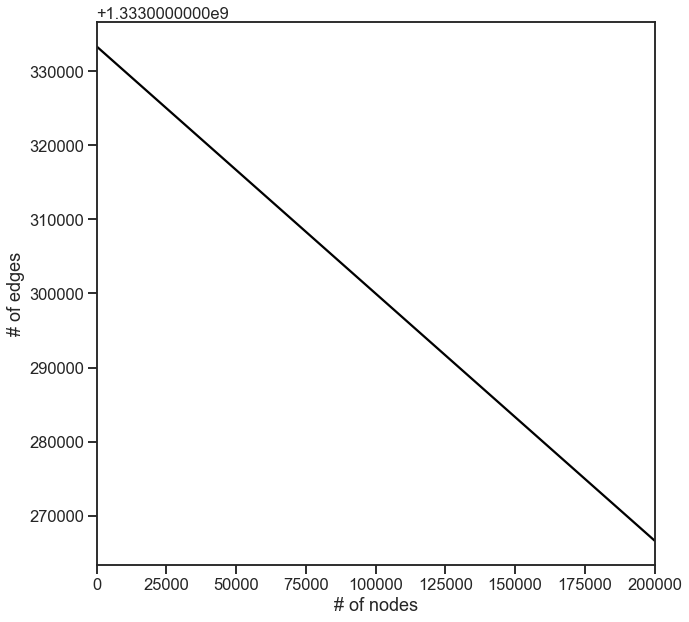

In [165]:
xs = np.linspace(10, 200_000, 100)
b = 16 * 1e9
ys = (b - 4 - 4*xs) / 12
# for i in range(len(ys)): 
#     if ys[i] > xs[i]**2:
#         ys[i] = xs[i]**2

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(xs, ys, color='black')
# ax.plot(xs, xs**2, color='blue')
# ax.set(xlim=(0, 10_000), ylim=(0, 100_000))
ax.set(xlim=(0, 200_000))
ax.set(xlabel='# of nodes', ylabel='# of edges')


In [89]:
# const = soln
# n_linear = soln[0]
# m_linear = soln[1] # 0
# n_squared = 

array([ 2.47636362e+02,  1.32000000e+00, -1.37861917e-12,  3.63636364e+01,
       -2.04208004e-11,  2.51430821e-14,  1.01152560e-10, -1.99554349e-13,
        0.00000000e+00])